In [2]:
import pandas as pd
import numpy as np

import texthero as hero
from texthero import preprocessing
import pickle
import matplotlib.pyplot as plt
from scipy.sparse import hstack

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Text Cleaning and Pre-processing
def preprocess_text(features):
    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets
    ]

    # apply pipeline to text
    clean_text = features.pipe(hero.clean, cleaning_pipeline)
    
    return clean_text

In [11]:
cols = ['EventDescription', 'ActionTaken', 'IncidentCause', 'IncidentConsequence', 'CauseCommunity', 'FailedAssets', 'CauseWorkP', 'CauseTechnical', 'CauseEnvironment', 'Category']

df = pd.read_csv('cleaned_incidents1.csv', usecols = cols)
df_original = df

# filling up missing values
df = df.dropna(axis=0, subset=['Category'])
df = df.replace(np.nan, '', regex=True)

# encode target
le = LabelEncoder()
y_train = le.fit_transform(df['Category'])

df = df.drop(columns=['Category'])

# clean texts
df = df.apply(lambda x: preprocess_text(x))

# vectorize
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=10, use_idf= True) 

columns = df.columns

# vectorize each column
description = ''    
col_len = []
feature_names = []
tfidf_col = []
for col in columns:
    tfidf_col.append(tfidf_vectorizer.fit_transform(df[col]))
    col_featureName = tfidf_vectorizer.get_feature_names()
    feature_names = feature_names + col_featureName
    col_len.append(len(col_featureName))

# collect vectors from all columns
x_train = hstack(tfidf_col).toarray()

featureName_len = len(feature_names)

print('col_len:', col_len)
print('featureName_len:', featureName_len)

print('x_train shape:', x_train.shape)

col_len: [941, 37, 36, 38, 15, 1697, 82, 696, 61]
featureName_len: 3603
x_train shape: (6489, 3603)


In [5]:
# feature selection
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3000)

# fit RFE
rfe.fit(x_train, y_train)
print('finish RFE')

# save model (only if you need)
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rfe, file)

finish RFE


In [97]:
# Load model from file (only if you need to)
with open(pkl_filename, 'rb') as file:
    rfe = pickle.load(file)

In [6]:
# save rfe result to dataframe
feature_df = pd.DataFrame({'col_name':'', 'col_word':feature_names, 'is_selected':rfe.support_,})
    
# add originated column name to rfe result
start_row = 0
for i in range(len(cols)-1):
    end_row = start_row + col_len[i]
    feature_df.loc[start_row:end_row - 1, 'col_name'] = cols[i]
    start_row = end_row

# prepare data for plotting
feature_count_df = feature_df[feature_df.is_selected].groupby('col_name')['col_word'].count().reset_index()
feature_count_df.sort_values(by=['col_word'], inplace=True, ascending=False)
feature_count_df

,col_name,col_word
6,FailedAssets,1261
5,EventDescription,904
3,CauseTechnical,596
4,CauseWorkP,82
8,IncidentConsequence,38
0,ActionTaken,37
7,IncidentCause,36
2,CauseEnvironment,31
1,CauseCommunity,15


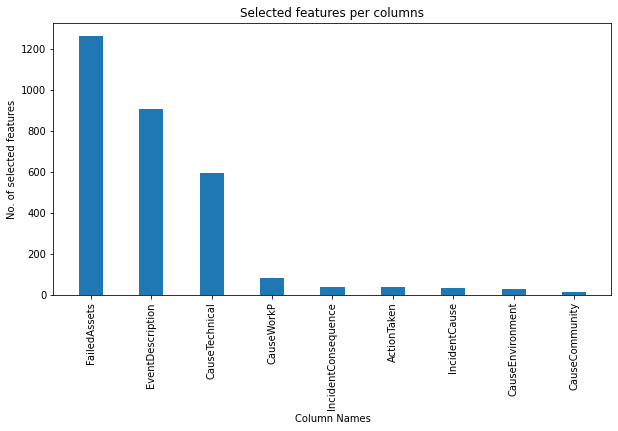

In [7]:
# plot

x = feature_count_df['col_name']
y = feature_count_df['col_word']

fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(x, y, width = 0.4) 
  
plt.xlabel("Column Names") 
plt.ylabel("No. of selected features") 
plt.title("Selected features per columns") 
plt.xticks(rotation=90)
plt.show() 

In [12]:
# save selected columns to csv
selected_cols = ['EventDescription', 'FailedAssets', 'CauseTechnical', 'Category']
selected_df = df_original[selected_cols] 
selected_df.to_csv('processed_dataset_backward.csv', index=False)

As you can see from the above result, the FailedAssets, EventDescription and CauseTechnical are the most relevant columns. 

In onder to be able to trace to the original columns, I vectorized each column then concat the results. This is not the case in classification, you must concat the columns then vectorize the data as a whole.

I only count number of selected features in each column and do not consider the ranks

RFE eliminate features with low weights (e.g., the coefficients of a linear model)

The following actions affected the result:
- Classification method 
- number of features selected during RFE
- min_df in tf-idf

RFE is not the best feature selection for text classification. This experiment only gives some guidance in order to select relevant columns